# Depression and Anxiety classification with CSP spatial filter and delta/theta frequency bands

Conceptual replication of the study by [Cavanagh et al. (2019)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6515849/) on own dataset.

Import packages

In [76]:
import io
import os
import mne
import copy
import glob
import array
import matplotlib
import numpy as np
import pandas as pd
import sklearn.metrics
import seaborn as sns
import scipy.io as sio
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import FeatureUnion

from itertools import chain

from scipy.io import loadmat
from scipy import stats

from sklearn import set_config
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, RepeatedStratifiedKFold
from sklearn.utils import resample

from autoreject import AutoReject

from collections import Counter

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.preprocessing import Xdawn
from mne.decoding import Vectorizer
from mne.decoding import UnsupervisedSpatialFilter

from sklearn.ensemble import BaggingClassifier


# parameters for plotting
plt.rcParams["figure.figsize"] = (10,7)

import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

Constatnts

In [2]:
random_state = 42
signal_frequency = 256

## Load EEG data

In [3]:
# file = 'data/sonata_data/feedback_export_MID/MID-012_Seg FEED incentive.vhdr'
# raw = mne.io.read_raw_brainvision(file, eog=('HEOG', 'VEOG'))
# events, event_ids = mne.events_from_annotations(raw)
# event_ids

In [4]:
def create_df_data(
    dir_path,
    info_filename=None,
    info="all",
    personal=True,
    task = 'FLA',
    reject_by_annotation=True
):
    """Loads data for all participants and create DataFrame with optional additional info from given .csv file.

    On default, loads a train set: chooses only 80% of participants
    and for each of them chooses 80% of epochs.
    It will choose them deterministically.

    Participants with less than 10 epochs per condition are rejected.

    If test_participants is set to True, it will load remaining 20% of participants.
    If test_epochs is set to True, it will load remaining 20% of epochs.
    Test epochs are chronologically after train epochs,
    because it reflects real usage (first callibration and then classification).

    Parameters
    ----------
    test_participants: bool
        whether load data for training or final testing.
        If true load participants data for testing.
    test_epochs: bool
        whether load data for training or final testing.
        If true load epochs of each participants data for testing.
    info_filename: String | None
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters
    personal: bool
        whether a model will be both trained and tested on epochs from one person
        if false, person's epochs aren't split into test and train


    Returns
    -------
    go_nogo_data_df : pandas.DataFrame

    """
    header_files_glob = os.path.join(os.path.abspath(""), dir_path + "*.vhdr")
    header_files = glob.glob(header_files_glob)

    header_files = sorted(header_files)
    go_nogo_data_df = pd.DataFrame()

    for file in header_files:
        #  load eeg data for given participant
        
        try:
            participant_epochs = load_epochs_from_file(file, task=task, reject_by_annotation=reject_by_annotation)

            # and compute participant's id from file_name
            participant_id = re.match(r".*-(\d+)_.*", file).group(1)

            f_bad = participant_epochs["f_bad"].get_data()
            f_good = participant_epochs["f_good"].get_data()

            # exclude those participants who have too few samples
            if len(f_bad) < 5 or len(f_good) < 5:
                # not enough data for this participant
                continue

            # construct dataframe for participant with: id|epoch_data|response_type|additional info...
            participant_df = create_df_from_epochs(
                participant_id, participant_epochs, info_filename, info
            )
            print(participant_id)
            go_nogo_data_df = go_nogo_data_df.append(participant_df, ignore_index=True)
        
        except:
            print("No matching events found for f_good (event id 0)")

    return go_nogo_data_df

In [5]:
def create_df_from_epochs(id, participant_epochs, info_filename, info):
    """Create df for each participant. DF structure is like: {id: String ; epoch: epoch_data ; marker: 1.0|0.0}
    1.0 means correct and 0.0 means error response.
    Default info extracted form .csv file is 'Rumination Full Scale' and participants' ids.
    With this info df structure is like:
    {id: String ; epoch: epoch_data ; marker: 1.0|0.0 ; File: id ; 'Rumination Full Scale': int}

    Parameters
    ----------
    id: String
        participant's id extracted from filename
    correct: array
        correct responses' data
    error: array
        error responses' data
    info_filename: String
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters

    Returns
    -------
    participant_df : pandas.DataFrame

    """
    participant_df = pd.DataFrame()
    info_df = pd.DataFrame()

    # get additional info from file
    if info_filename is not None:
        if info == "all":
            rumination_df = pd.read_csv(info_filename, dtype={'Demo_kod': object})
        else:
            rumination_df = pd.read_csv(info_filename, usecols=["Demo_kod"] + info)
        info_df = (
            rumination_df.loc[rumination_df["Demo_kod"] == id]
            .reset_index()
            .drop("index", axis=1)
        )
        
    epoch_df = pd.DataFrame({"id": [id], "epochs": [participant_epochs]}).join(
            info_df
        )
    participant_df = participant_df.append(epoch_df, ignore_index=True)

    return participant_df

In [6]:
def get_merged_events(raw, task):
    merged_events = None
    merged_event_dict = None
    
    if task == 'MID':
        event_dict = {
            'Stimulus/F_BAD____*ex*incentive*FB': 10001,
            'Stimulus/F_GOOD___*ex*incentive*FG': 10002,
        }

        # Map for merged correct/error response markers
        merged_event_dict = {"f_good": 0, "f_bad": 1}

        # Reconstruct the original events from Raw object
        events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

        # Merge correct/error response events
        merged_events = mne.merge_events(
            events,
            [10002],
            merged_event_dict["f_good"],
            replace_events=True,
        )

        merged_events = mne.merge_events(
            merged_events,
            [10001],
            merged_event_dict["f_bad"],
            replace_events=True,
        )
    elif task == 'GNG':
        event_dict = {
            'Stimulus/FB*ex*1_n*1_c_1*R': 10001,
            'Stimulus/FB*ex*2_n*2_c_1*R': 10002,
            'Stimulus/FG*ex*1_n*1_c_1*R': 10003,
            'Stimulus/FG*ex*2_n*2_c_1*R': 10004,
        }

        # Map for merged correct/error response markers
        merged_event_dict = {"f_good": 0, "f_bad": 1}

        # Reconstruct the original events from Raw object
        events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

        # Merge correct/error response events
        merged_events = mne.merge_events(
            events,
            [10003, 10004],
            merged_event_dict["f_good"],
            replace_events=True,
        )

        merged_events = mne.merge_events(
            merged_events,
            [10001, 10002],
            merged_event_dict["f_bad"],
            replace_events=True,
        )
        
    elif task == 'FLA':
        event_dict = {
            'Stimulus/F_BAD___*ex**lll*l*FB': 10001,
            'Stimulus/F_BAD___*ex**lrl*r*FB': 10002,
            'Stimulus/F_BAD___*ex**rlr*l*FB': 10003,
            'Stimulus/F_BAD___*ex**rrr*r*FB': 10004,
            'Stimulus/F_GOOD__*ex**lll*l*FG': 10005,
            'Stimulus/F_GOOD__*ex**lrl*r*FG': 10006,
            'Stimulus/F_GOOD__*ex**rlr*l*FG': 10007,
            'Stimulus/F_GOOD__*ex**rrr*r*FG': 10008,
        }

        # Map for merged correct/error response markers
        merged_event_dict = {"f_good": 0, "f_bad": 1}

        # Reconstruct the original events from Raw object
        events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

        # Merge correct/error response events
        merged_events = mne.merge_events(
            events,
            [10005, 10006, 10007, 10008],
            merged_event_dict["f_good"],
            replace_events=True,
        )

        merged_events = mne.merge_events(
            merged_events,
            [10001, 10002, 10003, 10004],
            merged_event_dict["f_bad"],
            replace_events=True,
        )
    return merged_events, merged_event_dict      

In [7]:
def load_epochs_from_file(file, task, reject_by_annotation=True, mask=None):
    """Load epochs from a header file.

    Args:
        file: path to a header file (.vhdr)
        reject_bad_segments: 'auto' means that bad segments are rejected automatically.

    Returns:
        mne Epochs

    """
    # Import the BrainVision data into an MNE Raw object
    raw = mne.io.read_raw_brainvision(file, eog=('HEOG', 'VEOG'))

    # Construct annotation filename
    annot_file = file[:-4] + "vmrk"

    # Read in the event information as MNE annotations
    annotations = mne.read_annotations(annot_file)

    # Add the annotations to our raw object so we can use them with the data
    raw.set_annotations(annotations)

    # Map with response markers only GNG
    merged_events, merged_event_dict = get_merged_events(raw, task)
    
    tmin=None
    tmax=None
    
    if task == 'FLA' or task == 'GNG':
        tmin, tmax = -1.0, 2.4  # Start and end of the segments
    elif task == 'MID':
        tmin, tmax = -0.2, 0.8  # Start and end of the segments

# Read epochs
    epochs = mne.Epochs(
        raw=raw,
        events=merged_events,
        event_id=merged_event_dict,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        reject_by_annotation=reject_by_annotation,
        preload=True,
        verbose=0,
    )

    if not reject_by_annotation:
        ar = AutoReject(random_state=random_state, n_jobs=10, verbose=0)
        epochs_ar, reject_log = ar.fit_transform(epochs, return_log=True)
        epochs = epochs_ar        
    
    return epochs

Choose the data to load

In [8]:
load_autoreject_data = True
task = 'GNG'

In [9]:
# %%capture
info_filename = 'data/sonata_data/questionnaires.csv'

if load_autoreject_data:
    df_name = f'sonata_data_{task}_autoreject'
    dir_name = f'data/sonata_data/feedback_export_{task}/'
    pickled_data_filename = 'data/sonata_data/' + df_name + '.pkl'

    if os.path.isfile(pickled_data_filename):
        print("Pickled file found. Loading pickled data...")
        data_df = pd.read_pickle(pickled_data_filename)
        data_df.name = df_name
        print("Done")
        pass
    else:
        print("Pickled file not found. Loading data...")
        data_df = create_df_data(
            dir_path=dir_name, 
            info="all", 
            personal=False, 
            info_filename=info_filename, 
            task=task,
            reject_by_annotation = False
        )
        
        data_df.name = df_name
        # save loaded data into a pickle file
        data_df.to_pickle("data/sonata_data/" + data_df.name + ".pkl")
        print("Done. Pickle file created")
else:
    
    df_name = f'sonata_data_{task}'
    dir_name = f'data/sonata_data/feedback_export_{task}/'
    pickled_data_filename = 'data/sonata_data/' + df_name + '.pkl'

    if os.path.isfile(pickled_data_filename):
        print("Pickled file found. Loading pickled data...")
        data_df = pd.read_pickle(pickled_data_filename)
        data_df.name = df_name
        print("Done")
        pass
    else:
        print("Pickled file not found. Loading data...")
        data_df = create_df_data(
            dir_path=dir_name, 
            info="all", 
            personal=False, 
            info_filename=info_filename, 
            task=task,
            reject_by_annotation = True
        )
        data_df.name = df_name
        # save loaded data into a pickle file
        data_df.to_pickle("data/sonata_data/" + data_df.name + ".pkl")
        print("Done. Pickle file created")

Pickled file found. Loading pickled data...


KeyboardInterrupt: 

In [25]:
data_df.head()

,id,epochs,Demo_kod,BDI,BDI_cognitive,BDI_affective,BDI_affect_cog,BDI_somatic,STAI,short_epochs
0,000,"<Epochs | 212 events (all good), -1 - 2.39844...",000,6,0.17,0.67,0.83,0.50,40,"<Epochs | 212 events (all good), -0.101562 - ..."
1,012,"<Epochs | 181 events (all good), -1 - 2.39844...",012,45,2.33,2.00,4.33,1.67,50,"<Epochs | 181 events (all good), -0.101562 - ..."
2,014,"<Epochs | 219 events (all good), -1 - 2.39844...",014,17,1.00,0.33,1.33,0.83,58,"<Epochs | 219 events (all good), -0.101562 - ..."
3,037,"<Epochs | 223 events (all good), -1 - 2.39844...",037,10,0.17,1.67,1.83,0.33,51,"<Epochs | 223 events (all good), -0.101562 - ..."
4,041,"<Epochs | 207 events (all good), -1 - 2.39844...",041,8,0.33,0.33,0.67,0.17,48,"<Epochs | 207 events (all good), -0.101562 - ..."
...,...,...,...,...,...,...,...,...,...,...
217,215,"<Epochs | 223 events (all good), -1 - 2.39844...",215,13,0.33,0.33,0.67,1.00,42,"<Epochs | 223 events (all good), -0.101562 - ..."
218,216,"<Epochs | 222 events (all good), -1 - 2.39844...",216,11,0.50,0.67,1.17,0.50,48,"<Epochs | 222 events (all good), -0.101562 - ..."
219,217,"<Epochs | 197 events (all good), -1 - 2.39844...",217,4,0.17,0.00,0.17,0.33,37,"<Epochs | 197 events (all good), -0.101562 - ..."
220,220,"<Epochs | 222 events (all good), -1 - 2.39844...",220,7,0.33,0.33,0.67,0.33,38,"<Epochs | 222 events (all good), -0.101562 - ..."


### Add frequency data

In [19]:
freq_ranges = [(0.1,2.0), (4.0,10.0)]

- add delta

In [20]:
%%capture

data_df['delta'] = data_df['epochs'].apply(lambda x: x.copy().filter(
    freq_ranges[0][0], 
    freq_ranges[0][1], 
    fir_design='firwin', 
    skip_by_annotation='edge',
    h_trans_bandwidth = 'auto',
))

In [21]:
data_df.head()

,id,epochs,Demo_kod,BDI,BDI_cognitive,BDI_affective,BDI_affect_cog,BDI_somatic,STAI,delta
0,000,"<Epochs | 80 events (all good), -0.199219 - 0...",000,6,0.17,0.67,0.83,0.50,40,"<Epochs | 80 events (all good), -0.199219 - 0..."
1,001,"<Epochs | 50 events (all good), -0.199219 - 0...",001,17,0.67,1.00,1.67,0.83,52,"<Epochs | 50 events (all good), -0.199219 - 0..."
2,002,"<Epochs | 32 events (all good), -0.199219 - 0...",002,4,0.33,0.33,0.67,0.00,50,"<Epochs | 32 events (all good), -0.199219 - 0..."
3,003,"<Epochs | 68 events (all good), -0.199219 - 0...",003,1,0.00,0.00,0.00,0.17,32,"<Epochs | 68 events (all good), -0.199219 - 0..."
4,004,"<Epochs | 57 events (all good), -0.199219 - 0...",004,5,0.33,0.33,0.67,0.00,46,"<Epochs | 57 events (all good), -0.199219 - 0..."


- add theta

In [22]:
%%capture

data_df['theta'] = data_df['epochs'].apply(lambda x: x.copy().filter(
    freq_ranges[1][0], 
    freq_ranges[1][1], 
    fir_design='firwin', 
    skip_by_annotation='edge',
    h_trans_bandwidth = 'auto',
))

In [23]:
data_df

,id,epochs,Demo_kod,BDI,BDI_cognitive,BDI_affective,BDI_affect_cog,BDI_somatic,STAI,delta,theta
0,000,"<Epochs | 80 events (all good), -0.199219 - 0...",000,6,0.17,0.67,0.83,0.50,40,"<Epochs | 80 events (all good), -0.199219 - 0...","<Epochs | 80 events (all good), -0.199219 - 0..."
1,001,"<Epochs | 50 events (all good), -0.199219 - 0...",001,17,0.67,1.00,1.67,0.83,52,"<Epochs | 50 events (all good), -0.199219 - 0...","<Epochs | 50 events (all good), -0.199219 - 0..."
2,002,"<Epochs | 32 events (all good), -0.199219 - 0...",002,4,0.33,0.33,0.67,0.00,50,"<Epochs | 32 events (all good), -0.199219 - 0...","<Epochs | 32 events (all good), -0.199219 - 0..."
3,003,"<Epochs | 68 events (all good), -0.199219 - 0...",003,1,0.00,0.00,0.00,0.17,32,"<Epochs | 68 events (all good), -0.199219 - 0...","<Epochs | 68 events (all good), -0.199219 - 0..."
4,004,"<Epochs | 57 events (all good), -0.199219 - 0...",004,5,0.33,0.33,0.67,0.00,46,"<Epochs | 57 events (all good), -0.199219 - 0...","<Epochs | 57 events (all good), -0.199219 - 0..."
...,...,...,...,...,...,...,...,...,...,...,...
211,220,"<Epochs | 87 events (all good), -0.199219 - 0...",220,7,0.33,0.33,0.67,0.33,38,"<Epochs | 87 events (all good), -0.199219 - 0...","<Epochs | 87 events (all good), -0.199219 - 0..."
212,221,"<Epochs | 39 events (all good), -0.199219 - 0...",221,27,0.67,1.67,2.33,1.83,54,"<Epochs | 39 events (all good), -0.199219 - 0...","<Epochs | 39 events (all good), -0.199219 - 0..."
213,222,"<Epochs | 86 events (all good), -0.199219 - 0...",222,12,0.17,0.00,0.17,1.50,49,"<Epochs | 86 events (all good), -0.199219 - 0...","<Epochs | 86 events (all good), -0.199219 - 0..."
214,223,"<Epochs | 70 events (all good), -0.199219 - 0...",223,0,0.00,0.00,0.00,0.00,31,"<Epochs | 70 events (all good), -0.199219 - 0...","<Epochs | 70 events (all good), -0.199219 - 0..."


In [24]:
data_df.to_pickle("data/sonata_data/" + data_df.name + "_freq.pkl")

## Define groups

In [9]:
data_df = pd.read_pickle('data/sonata_data/sonata_data_GNG_autoreject_freq_short.pkl')

In [10]:
data_df

,id,epochs,Demo_kod,BDI,BDI_cognitive,BDI_affective,BDI_affect_cog,BDI_somatic,STAI,delta,theta
0,000,"<Epochs | 212 events (all good), -1 - 2.39844...",000,6,0.17,0.67,0.83,0.50,40,"<Epochs | 212 events (all good), 0 - 0.5 sec,...","<Epochs | 212 events (all good), 0 - 0.5 sec,..."
1,012,"<Epochs | 181 events (all good), -1 - 2.39844...",012,45,2.33,2.00,4.33,1.67,50,"<Epochs | 181 events (all good), 0 - 0.5 sec,...","<Epochs | 181 events (all good), 0 - 0.5 sec,..."
2,014,"<Epochs | 219 events (all good), -1 - 2.39844...",014,17,1.00,0.33,1.33,0.83,58,"<Epochs | 219 events (all good), 0 - 0.5 sec,...","<Epochs | 219 events (all good), 0 - 0.5 sec,..."
3,037,"<Epochs | 223 events (all good), -1 - 2.39844...",037,10,0.17,1.67,1.83,0.33,51,"<Epochs | 223 events (all good), 0 - 0.5 sec,...","<Epochs | 223 events (all good), 0 - 0.5 sec,..."
4,041,"<Epochs | 207 events (all good), -1 - 2.39844...",041,8,0.33,0.33,0.67,0.17,48,"<Epochs | 207 events (all good), 0 - 0.5 sec,...","<Epochs | 207 events (all good), 0 - 0.5 sec,..."
...,...,...,...,...,...,...,...,...,...,...,...
217,215,"<Epochs | 223 events (all good), -1 - 2.39844...",215,13,0.33,0.33,0.67,1.00,42,"<Epochs | 223 events (all good), 0 - 0.5 sec,...","<Epochs | 223 events (all good), 0 - 0.5 sec,..."
218,216,"<Epochs | 222 events (all good), -1 - 2.39844...",216,11,0.50,0.67,1.17,0.50,48,"<Epochs | 222 events (all good), 0 - 0.5 sec,...","<Epochs | 222 events (all good), 0 - 0.5 sec,..."
219,217,"<Epochs | 197 events (all good), -1 - 2.39844...",217,4,0.17,0.00,0.17,0.33,37,"<Epochs | 197 events (all good), 0 - 0.5 sec,...","<Epochs | 197 events (all good), 0 - 0.5 sec,..."
220,220,"<Epochs | 222 events (all good), -1 - 2.39844...",220,7,0.33,0.33,0.67,0.33,38,"<Epochs | 222 events (all good), 0 - 0.5 sec,...","<Epochs | 222 events (all good), 0 - 0.5 sec,..."


In [ ]:
ids = np.load('data/sonata_data/ids/gng_fla_common_ids_autoreject.npy')
ids.sort()
len(ids)

In [ ]:
data_df = data_df[data_df['id'].isin(ids)]
data_df.shape

In [11]:
dep = data_df[(data_df['BDI'] > 13) & (data_df['STAI'] > 41)]
len(dep)

75

In [12]:
ctrl_dep = data_df[(data_df['BDI'] <= 13) & (data_df['STAI'] > 41)]
len(ctrl_dep)

72

In [293]:
anx = data_df[(data_df['BDI'] <= 13) & (data_df['STAI'] > 42)]
len(anx)

65

In [294]:
ctrl_anx = data_df[(data_df['BDI'] <= 13) & (data_df['STAI'] < 41)]
len(ctrl_anx)

66

### Summary of groups stats

In [19]:
def df_add_demo_info(demo_file_name, df):
    demo_df = pd.read_csv(f'data/sonata_data/{demo_file_name}', dtype={'Demo_kod': object}, usecols=[
        'Demo_kod',
        'Płeć', 
        'Ręczność',
        'Wiek',
        'Wzrost',
        'Waga',
        'Twoja dotychczasowa liczba lat edukacji (w pełnych latach)'
        ]
    )
        
    demo_df.set_index('Demo_kod', inplace=True)
    
    group_indexes = df['Demo_kod'].to_list()
    demo_ = demo_df.loc[group_indexes]
        
    df_indexed = df.set_index('Demo_kod')
    
    df_demo = pd.concat([df_indexed,demo_], axis=1)
        
    df_demo.rename(columns = {
        'Płeć':'Sex',
        'Wiek': 'Age',
        'Ręczność': 'Handedness',
        'Wzrost': 'Height',
        'Waga': 'Weight',
        'Twoja dotychczasowa liczba lat edukacji (w pełnych latach)':'Education (years)'
    }, inplace=True)
    
    df_demo['Sex'] = df_demo['Sex'].astype(float)
    
    return df_demo

Full sample

In [20]:
demo_df = pd.read_csv(f'data/sonata_data/Sonata_scales.csv', dtype={'Demo_kod': object}, usecols=[
        'Demo_kod',
        'Płeć', 
        'Ręczność',
        'Wiek',
        'Wzrost',
        'Waga',
        'Twoja dotychczasowa liczba lat edukacji (w pełnych latach)'
        ]
)

demo_df.describe()

,Płeć,Ręczność,Wiek,Wzrost,Waga,Twoja dotychczasowa liczba lat edukacji (w pełnych latach)
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,0.495556,0.897778,23.640000,173.153333,68.186222,15.413333
std,0.499980,0.303616,4.176807,9.633220,14.820595,2.400298
min,0.000000,0.000000,18.000000,152.000000,20.000000,9.000000
25%,0.000000,1.000000,21.000000,165.000000,58.000000,14.000000
50%,0.000000,1.000000,23.000000,173.000000,66.000000,15.000000
75%,1.000000,1.000000,25.000000,180.000000,76.000000,17.000000
max,1.000000,1.000000,39.000000,200.000000,142.000000,25.000000


In [21]:
demo_df

,Demo_kod,Płeć,Ręczność,Wiek,Wzrost,Waga,Twoja dotychczasowa liczba lat edukacji (w pełnych latach)
0,000,0.0,1,26,170.0,53.0,20
1,001,0.0,1,21,155.0,50.0,15
2,002,0.0,1,19,159.0,65.0,15
3,003,0.0,1,36,168.0,92.0,23
4,004,0.0,1,27,166.0,61.0,18
...,...,...,...,...,...,...,...
220,220,0.0,1,23,164.0,62.0,17
221,221,0.0,1,22,178.0,66.0,15
222,222,0.0,1,21,164.0,79.0,14
223,223,0.0,1,24,169.0,66.0,12


In [22]:
sex = demo_df['Płeć'].to_list()

print(Counter(sex).keys()) # equals to list(set(words))
print(Counter(sex).values()) # counts the elements' frequency

dict_keys([0.0, 1.0, 0.5])
dict_values([113, 111, 1])


Sample after artifact rejection

In [23]:
data_full_demo_df = df_add_demo_info(demo_file_name = 'Sonata_scales.csv', df=data_df)
data_full_demo_df.describe()

,BDI,BDI_cognitive,BDI_affective,BDI_affect_cog,BDI_somatic,STAI,Sex,Handedness,Age,Height,Weight,Education (years)
count,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000
mean,11.959459,0.514324,0.499324,1.014550,0.611171,45.567568,0.493243,0.896396,23.558559,173.186937,68.062613,15.409910
std,10.231845,0.549190,0.544566,0.995998,0.503103,9.136097,0.499954,0.305434,4.096538,9.569345,14.759695,2.408223
min,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000,0.000000,18.000000,152.000000,20.000000,9.000000
25%,5.000000,0.170000,0.000000,0.210000,0.170000,39.000000,0.000000,1.000000,21.000000,165.250000,57.250000,14.000000
50%,9.000000,0.330000,0.330000,0.670000,0.500000,45.000000,0.000000,1.000000,23.000000,173.000000,66.000000,15.000000
75%,16.750000,0.830000,0.670000,1.500000,0.830000,52.000000,1.000000,1.000000,25.000000,180.000000,76.000000,17.000000
max,48.000000,2.830000,2.330000,5.170000,2.330000,70.000000,1.000000,1.000000,39.000000,200.000000,142.000000,25.000000


In [24]:
sex = data_full_demo_df['Sex'].to_list()

print(Counter(sex).keys()) # equals to list(set(words))
print(Counter(sex).values()) # counts the elements' frequency

dict_keys([0.0, 1.0, 0.5])
dict_values([112, 109, 1])


Groups

In [25]:
dep_demo = df_add_demo_info(demo_file_name = 'Sonata_scales.csv', df=dep)
dep_demo.describe()

,BDI,BDI_cognitive,BDI_affective,BDI_affect_cog,BDI_somatic,STAI,Sex,Handedness,Age,Height,Weight,Education (years)
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,23.466667,1.053333,0.977067,2.031067,1.093467,54.106667,0.413333,0.893333,23.080000,171.133333,64.980000,15.466667
std,8.855191,0.570844,0.588644,0.993065,0.474545,6.235412,0.495748,0.310768,3.451439,9.719489,12.538169,2.372895
min,14.000000,0.000000,0.000000,0.670000,0.330000,42.000000,0.000000,0.000000,18.000000,155.000000,45.000000,11.000000
25%,16.000000,0.670000,0.330000,1.330000,0.830000,50.000000,0.000000,1.000000,21.000000,163.500000,55.000000,14.000000
50%,21.000000,1.000000,1.000000,1.830000,1.000000,55.000000,0.000000,1.000000,23.000000,169.000000,64.000000,15.000000
75%,28.500000,1.170000,1.330000,2.500000,1.330000,58.000000,1.000000,1.000000,25.000000,177.500000,71.000000,17.000000
max,48.000000,2.830000,2.330000,5.170000,2.330000,70.000000,1.000000,1.000000,38.000000,198.000000,97.000000,25.000000


In [26]:
sex = dep_demo['Sex'].to_list()

print(Counter(sex).keys()) # equals to list(set(words))
print(Counter(sex).values()) # counts the elements' frequency

dict_keys([1.0, 0.0])
dict_values([31, 44])


In [27]:
dep_ctrl_demo = df_add_demo_info(demo_file_name = 'Sonata_scales.csv', df=ctrl_dep)
dep_ctrl_demo.describe()

,BDI,BDI_cognitive,BDI_affective,BDI_affect_cog,BDI_somatic,STAI,Sex,Handedness,Age,Height,Weight,Education (years)
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.00000,72.000000,72.000000,72.000000,72.000000
mean,7.069444,0.310139,0.300278,0.611667,0.389028,47.194444,0.437500,0.87500,23.361111,172.381944,67.402778,15.055556
std,3.678358,0.271451,0.318044,0.426902,0.294351,3.550992,0.496023,0.33304,4.280008,8.794802,17.550458,2.075266
min,0.000000,0.000000,0.000000,0.000000,0.000000,42.000000,0.000000,0.00000,18.000000,155.000000,20.000000,9.000000
25%,4.000000,0.000000,0.000000,0.290000,0.170000,45.000000,0.000000,1.00000,20.000000,165.000000,56.750000,14.000000
50%,7.000000,0.330000,0.330000,0.670000,0.330000,47.000000,0.000000,1.00000,22.000000,172.500000,63.500000,15.000000
75%,11.000000,0.500000,0.330000,0.830000,0.500000,50.000000,1.000000,1.00000,25.000000,179.250000,76.500000,16.250000
max,13.000000,1.170000,1.670000,1.830000,1.500000,55.000000,1.000000,1.00000,39.000000,190.000000,142.000000,20.000000


In [28]:
sex = dep_ctrl_demo['Sex'].to_list()

print(Counter(sex).keys()) # equals to list(set(words))
print(Counter(sex).values()) # counts the elements' frequency

dict_keys([0.0, 1.0, 0.5])
dict_values([40, 31, 1])


In [29]:
anx_demo = df_add_demo_info(demo_file_name = 'Sonata_scales.csv', df=anx)
anx_demo.describe()

,BDI,BDI_cognitive,BDI_affective,BDI_affect_cog,BDI_somatic,STAI,Sex,Handedness,Age,Height,Weight,Education (years)
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.00000,72.000000,72.000000,72.000000,72.000000
mean,7.069444,0.310139,0.300278,0.611667,0.389028,47.194444,0.437500,0.87500,23.361111,172.381944,67.402778,15.055556
std,3.678358,0.271451,0.318044,0.426902,0.294351,3.550992,0.496023,0.33304,4.280008,8.794802,17.550458,2.075266
min,0.000000,0.000000,0.000000,0.000000,0.000000,42.000000,0.000000,0.00000,18.000000,155.000000,20.000000,9.000000
25%,4.000000,0.000000,0.000000,0.290000,0.170000,45.000000,0.000000,1.00000,20.000000,165.000000,56.750000,14.000000
50%,7.000000,0.330000,0.330000,0.670000,0.330000,47.000000,0.000000,1.00000,22.000000,172.500000,63.500000,15.000000
75%,11.000000,0.500000,0.330000,0.830000,0.500000,50.000000,1.000000,1.00000,25.000000,179.250000,76.500000,16.250000
max,13.000000,1.170000,1.670000,1.830000,1.500000,55.000000,1.000000,1.00000,39.000000,190.000000,142.000000,20.000000


In [30]:
sex = anx_demo['Sex'].to_list()

print(Counter(sex).keys()) # equals to list(set(words))
print(Counter(sex).values()) # counts the elements' frequency

dict_keys([0.0, 1.0, 0.5])
dict_values([40, 31, 1])


In [31]:
anx_ctrl_demo = df_add_demo_info(demo_file_name = 'Sonata_scales.csv', df=ctrl_anx)
anx_ctrl_demo.describe()

,BDI,BDI_cognitive,BDI_affective,BDI_affect_cog,BDI_somatic,STAI,Sex,Handedness,Age,Height,Weight,Education (years)
count,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000
mean,4.549296,0.150563,0.182394,0.333662,0.311972,35.323944,0.619718,0.915493,24.183099,175.929577,71.478873,15.704225
std,3.294102,0.198997,0.262844,0.387181,0.275082,4.351600,0.488911,0.280126,4.542843,9.726729,12.970141,2.774344
min,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000,0.000000,19.000000,152.000000,45.000000,12.000000
25%,2.000000,0.000000,0.000000,0.000000,0.170000,32.000000,0.000000,1.000000,21.000000,169.500000,62.000000,14.000000
50%,5.000000,0.170000,0.000000,0.170000,0.330000,36.000000,1.000000,1.000000,23.000000,176.000000,71.000000,15.000000
75%,7.000000,0.170000,0.330000,0.585000,0.500000,39.000000,1.000000,1.000000,26.000000,183.000000,80.500000,17.000000
max,12.000000,1.000000,1.330000,1.500000,1.330000,41.000000,1.000000,1.000000,39.000000,200.000000,107.000000,24.000000


In [32]:
sex = anx_ctrl_demo['Sex'].to_list()

print(Counter(sex).keys()) # equals to list(set(words))
print(Counter(sex).values()) # counts the elements' frequency

dict_keys([0.0, 1.0])
dict_values([27, 44])


### Visualize data

In [17]:
# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#     display(data_df)

- Good and Bad feedback

In [18]:
data_rewp = [epoch['f_good'].average().get_data(tmin=-0.1, tmax=0.6, picks='FCz') for epoch in data_df['epochs']]
data_frn = [epoch['f_bad'].average().get_data(tmin=-0.1, tmax=0.6, picks='FCz') for epoch in data_df['epochs']]

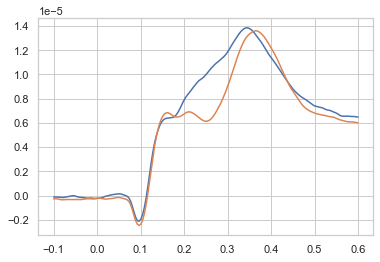

In [19]:
plt.plot(np.linspace(-0.1, 0.6, 179), np.nanmean(data_rewp, axis=0)[0])
plt.plot(np.linspace(-0.1, 0.6, 179), np.nanmean(data_frn, axis=0)[0])

- depression

In [17]:
dep_data_rewp = [epoch['f_good'].average().get_data(tmin=-0.1, tmax=0.6, picks='FCz') for epoch in dep['epochs']]
dep_data_frn = [epoch['f_bad'].average().get_data(tmin=-0.1, tmax=0.6, picks='FCz') for epoch in dep['epochs']]
ctrl_dep_data_rewp = [epoch['f_good'].average().get_data(tmin=-0.1, tmax=0.6, picks='FCz') for epoch in ctrl_dep['epochs']]
ctrl_dep_data_frn = [epoch['f_bad'].average().get_data(tmin=-0.1, tmax=0.6, picks='FCz') for epoch in ctrl_dep['epochs']]

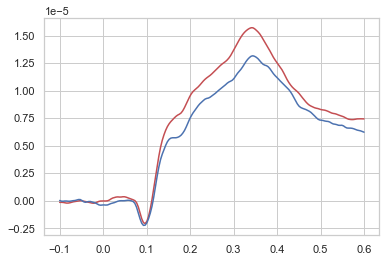

In [18]:
plt.plot(np.linspace(-0.1, 0.6, 179), np.nanmean(dep_data_rewp, axis=0)[0], color='r')
# plt.plot(np.linspace(-0.1, 0.6, 179), np.nanmean(dep_data_frn, axis=0)[0])
plt.plot(np.linspace(-0.1, 0.6, 179), np.nanmean(ctrl_dep_data_rewp, axis=0)[0], color='b')
# plt.plot(np.linspace(-0.1, 0.6, 179), np.nanmean(ctrl_dep_data_frn, axis=0)[0])

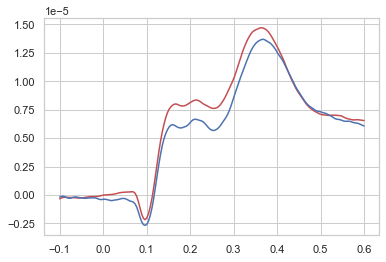

In [19]:
# plt.plot(np.linspace(-0.1, 0.6, 179), np.nanmean(dep_data_rewp, axis=0)[0])
plt.plot(np.linspace(-0.1, 0.6, 179), np.nanmean(dep_data_frn, axis=0)[0], color='r')
# plt.plot(np.linspace(-0.1, 0.6, 179), np.nanmean(ctrl_dep_data_rewp, axis=0)[0])
plt.plot(np.linspace(-0.1, 0.6, 179), np.nanmean(ctrl_dep_data_frn, axis=0)[0], color='b')

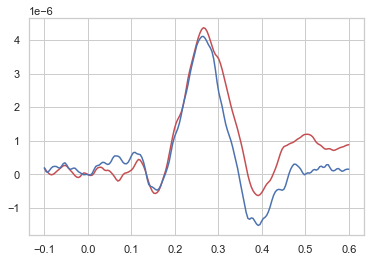

In [20]:
plt.plot(np.linspace(-0.1, 0.6, 179), (np.nanmean(dep_data_rewp, axis=0)[0] - np.nanmean(dep_data_frn, axis=0)[0]), color='r')
plt.plot(np.linspace(-0.1, 0.6, 179), (np.nanmean(ctrl_dep_data_rewp, axis=0)[0] - np.nanmean(ctrl_dep_data_frn, axis=0)[0]), color='b')

- anxiety

In [33]:
anx_data_rewp = [epoch['f_good'].average().get_data(tmin=-0.1, tmax=0.6, picks='FCz') for epoch in anx['epochs']]
anx_data_frn = [epoch['f_bad'].average().get_data(tmin=-0.1, tmax=0.6, picks='FCz') for epoch in anx['epochs']]
ctrl_anx_data_rewp = [epoch['f_good'].average().get_data(tmin=-0.1, tmax=0.6, picks='FCz') for epoch in ctrl_anx['epochs']]
ctrl_anx_data_frn = [epoch['f_bad'].average().get_data(tmin=-0.1, tmax=0.6, picks='FCz') for epoch in ctrl_anx['epochs']]

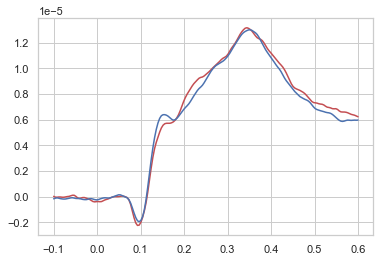

In [34]:
plt.plot(np.linspace(-0.1, 0.6, 179), np.nanmean(anx_data_rewp, axis=0).reshape(-1), color = 'r')
# plt.plot(np.linspace(-0.1, 0.6, 179), np.mean(anx_data_frn, axis=0)[0])
plt.plot(np.linspace(-0.1, 0.6, 179), np.nanmean(ctrl_anx_data_rewp, axis=0).reshape(-1), color = 'b')
# plt.plot(np.linspace(-0.1, 0.6, 179), np.mean(ctrl_anx_data_frn, axis=0)[0])

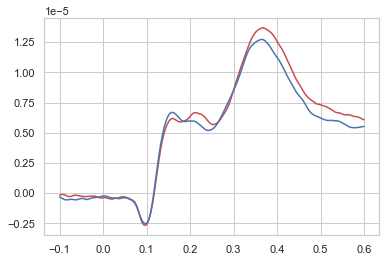

In [35]:
# plt.plot(np.linspace(-0.1, 0.6, 179), np.mean(anx_data_rewp, axis=0)[0])
plt.plot(np.linspace(-0.1, 0.6, 179), np.nanmean(anx_data_frn, axis=0)[0], color='r')
# plt.plot(np.linspace(-0.1, 0.6, 179), np.mean(ctrl_anx_data_rewp, axis=0)[0])
plt.plot(np.linspace(-0.1, 0.6, 179), np.nanmean(ctrl_anx_data_frn, axis=0)[0], color='b')

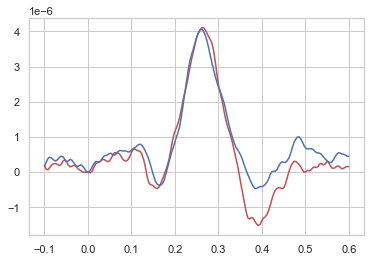

In [36]:
plt.plot(np.linspace(-0.1, 0.6, 179), (np.nanmean(anx_data_rewp, axis=0)[0] - np.nanmean(anx_data_frn, axis=0)[0]), color='r')
plt.plot(np.linspace(-0.1, 0.6, 179), (np.nanmean(ctrl_anx_data_rewp, axis=0)[0] - np.nanmean(ctrl_anx_data_frn, axis=0)[0]), color='b')

## Classification

In [37]:
# Calculating p-value with permutation test from sci-kit learn

def calculate_p_permutations(estimator, X, y, cv=5, n_permutations=1000, n_jobs=1):

    score_, perm_scores_, pvalue_ = permutation_test_score(
        estimator, X, y, cv=cv, n_permutations=n_permutations, n_jobs=n_jobs
    )

    # summarize
    print(f"     The permutation P-value is = {pvalue_:.4f}")
    print(f"     The permutation score is = {score_:.4f}\n")

    return score_, pvalue_

In [38]:
def evaluate_GS_model(
    pipe,
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    classifier_params,
    pipeline_name,
    cv=StratifiedKFold(n_splits=5),
    predict_test = True,
    predict_train = True,
    ):
    
    # define grid search
    grid_search_model = GridSearchCV(
        pipe,
        classifier_params,
        cv=cv,
        scoring={"roc_auc", "balanced_accuracy", "precision", "recall"},
        refit="balanced_accuracy",
        return_train_score=True,
        verbose=10,
        n_jobs=1,
        
    )

    # fit model
    grid_search_model.fit(X_train, y_train)

    # predict test data
    # y_test_pred = grid_search_model.predict(X_test) if predict_test is True else None
    # test_score = roc_auc_score(y_test, y_test_pred) if predict_test is True else None

    # predict train data
    y_train_pred = grid_search_model.predict(X_train) if predict_train is True else None
    train_score = roc_auc_score(y_train, y_train_pred) if predict_train is True else None 

    # extract mean cv scores
    mean_cv_score = grid_search_model.best_score_
    
    # report
    # classification_report_ = classification_report(y_test, y_test_pred, labels=[0,1])

    # extract splits scores
    # ta linijka wyciąga z cv_results, czyli z DF z wynikami wszystkich testowanych 
    # w GS parametrów scory na kolejnych splitach cross-validacji
    cv_results_df = pd.DataFrame(grid_search_model.cv_results_).iloc[[grid_search_model.best_index_]]
    cv_splits_scores_df = cv_results_df.filter(regex=r"split\d*_test_roc_auc").reset_index(drop=True) 

    # wyciąganie scorów na teście dla matryk zdefiniowanych w scoring
    metrics_results_df = cv_results_df.filter(regex=r"mean_test_*").reset_index(drop=True)
    
    # calculate p-value
    cv_p = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores_, pvalue_ = calculate_p_permutations(
            grid_search_model.best_estimator_, X_train, y_train, cv=cv_p
        )

    # save results in dataframe
    this_result = pd.concat(
        [
            pd.DataFrame({
            "model_name": [pipe.steps[-1][0]],
            "pipeline_name": [pipeline_name],
            "train score": [train_score],
            "mean_cv_score": [mean_cv_score],
            # "test_score": [test_score],
            "best_model": [grid_search_model.best_estimator_],
            "parameters": [grid_search_model.best_params_],
            "pvalue":[pvalue_],    
            }),
         # cv_splits_scores_df,
         metrics_results_df,
        ],
    axis=1
    ) 

    return this_result

In [192]:
class GetScale(TransformerMixin, BaseEstimator):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_new = np.array([[participant[1]] for participant in X])
        print(X_new.shape)
        return X_new

In [193]:
class GetEEG(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_new = np.array([participant[0] for participant in X])
        print(X_new.shape)
        return X_new

Define estimators

In [39]:
lg = ('lg', LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'))
lg_params = dict()

svc = ('svc' , SVC())
svc_params = dict(
    svc__kernel=["linear"],
    svc__C=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
)

lda = ("lda", LinearDiscriminantAnalysis())
lda_params = dict(
    lda__solver = ["lsqr", "eigen"],
    lda__shrinkage = ["auto"],
)


estimators = [
    # (lg, lg_params),
    (svc, svc_params),
    # (lda, lda_params)
]

Define CSP

In [41]:
csp = ('csp', CSP(log=None, norm_trace=False))
csp_params = dict(
    csp__n_components = [2, 3, 4],
    csp__reg = [0.001, 0.001, 0.01, 0.1]
)

In [194]:
csp = ('csp', CSP(log=None, norm_trace=False))
csp_params = dict(
    features__csp2__csp__n_components = [2, 3, 4],
    features__csp2__csp__reg = [0.001, 0.001, 0.01, 0.1]
)

### Depression vs Control

#### RewP

- STAI + EEG

In [162]:
tmin = 0.20
tmax = 0.30

In [163]:
picks=['']

In [202]:
rewp_depression_datasets = []
frequencies = ['delta', 'theta']

for freq in frequencies:
    dep_data_eeg = [mne.filter.resample(epoch['f_good'].average().get_data(tmin=tmin, tmax=tmax,), down=1.0) for epoch in dep[freq].to_numpy()]
    dep_stai = dep['STAI'].to_list()
    dep_data = list(zip(dep_data_eeg,dep_stai))
    
    ctrl_data_eeg = [mne.filter.resample(epoch['f_good'].average().get_data(tmin=tmin, tmax=tmax,), down=1.0) for epoch in ctrl_dep[freq].to_numpy()]
    ctrl_stai = ctrl_dep['STAI'].to_list()
    ctrl_data = list(zip(ctrl_data_eeg, ctrl_stai))
    
    X = dep_data + ctrl_data
    rewp_depression_datasets.append(X)

In [197]:
%%capture
vec = Vectorizer()
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=random_state)
# cv = LeaveOneOut()
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scaler = ('scaler', StandardScaler())

results_dep_rewp_stai_csp_df = pd.DataFrame()

global_params = csp_params

for index, dataset in enumerate(rewp_depression_datasets):

    X = dataset
    y = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
    
    for (estimator, params) in estimators:
        print(f"Rating {estimator} \n")

        pipeline_name = f"RewP_Depression_band_{str(index)}_stai_{estimator[0]}"
        
        clf_csp = Pipeline([('eeg', GetEEG())] + [csp] + [('vec', vec)])
        clf_stai = Pipeline([('scale', GetScale())])
        
        combined_features = FeatureUnion([("csp2", clf_csp), ("stai", clf_stai)])

        clf = Pipeline([("features", combined_features)] + [scaler] + [estimator])
        classifier_params = {**global_params, **params}
        
        print(clf)

        # enter to grid search
        grid_result = evaluate_GS_model(
            clf,
            X,
            y,
            [],
            [],
            classifier_params = classifier_params,
            pipeline_name = pipeline_name,
            cv=cv,
        )

        print(grid_result)

        results_dep_rewp_stai_csp_df = pd.concat([results_dep_rewp_stai_csp_df, grid_result])

In [295]:
results_dep_rewp_stai_csp_df 

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,mean_test_recall,mean_test_balanced_accuracy,mean_test_precision,mean_test_roc_auc
0,svc,RewP_Depression_band_0_stai_svc,0.742222,0.783611,"(FeatureUnion(transformer_list=[('csp2',\n ...","{'features__csp2__csp__n_components': 2, 'feat...",0.000999,0.72,0.783611,0.831169,0.826667
0,svc,RewP_Depression_band_1_stai_svc,0.749444,0.749722,"(FeatureUnion(transformer_list=[('csp2',\n ...","{'features__csp2__csp__n_components': 2, 'feat...",0.000999,0.68,0.749722,0.797980,0.803889


In [83]:
results_dep_rewp_df.to_pickle(f"data/sonata_data/results/{task}/depression_rewp_freq_results_t20-t30_28_06_sonata_lin.pkl")

#### FRN

- STAI + EEG

In [296]:
tmin = 0.20
tmax = 0.30

In [297]:
frn_depression_datasets = []
frequencies = ['delta', 'theta']

for freq in frequencies:
    dep_data_eeg = [mne.filter.resample(epoch['f_bad'].average().get_data(tmin=tmin, tmax=tmax,), down=1.0) for epoch in dep[freq].to_numpy()]
    dep_stai = dep['STAI'].to_list()
    dep_data = list(zip(dep_data_eeg,dep_stai))
    
    ctrl_data_eeg = [mne.filter.resample(epoch['f_bad'].average().get_data(tmin=tmin, tmax=tmax,), down=1.0) for epoch in ctrl_dep[freq].to_numpy()]
    ctrl_stai = ctrl_dep['STAI'].to_list()
    ctrl_data = list(zip(ctrl_data_eeg, ctrl_stai))
    
    X = dep_data + ctrl_data
    frn_depression_datasets.append(X)

In [298]:
%%capture
vec = Vectorizer()
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=random_state)
# cv = LeaveOneOut()
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scaler = ('scaler', StandardScaler())

results_dep_frn_stai_csp_df = pd.DataFrame()

global_params = csp_params

for index, dataset in enumerate(frn_depression_datasets):

    X = dataset
    y = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
    
    for (estimator, params) in estimators:
        print(f"Rating {estimator} \n")

        pipeline_name = f"FRN_Depression_band_{str(index)}_stai_{estimator[0]}"
        
        clf_csp = Pipeline([('eeg', GetEEG())] + [csp] + [('vec', vec)])
        clf_stai = Pipeline([('scale', GetScale())])
        
        combined_features = FeatureUnion([("csp2", clf_csp), ("stai", clf_stai)])

        clf = Pipeline([("features", combined_features)] + [scaler] + [estimator])
        classifier_params = {**global_params, **params}
        
        print(clf)

        # enter to grid search
        grid_result = evaluate_GS_model(
            clf,
            X,
            y,
            [],
            [],
            classifier_params = classifier_params,
            pipeline_name = pipeline_name,
            cv=cv,
        )

        print(grid_result)

        results_dep_frn_stai_csp_df = pd.concat([results_dep_frn_stai_csp_df, grid_result])

In [299]:
results_dep_frn_stai_csp_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,mean_test_recall,mean_test_balanced_accuracy,mean_test_precision,mean_test_roc_auc
0,svc,FRN_Depression_band_0_stai_svc,0.803889,0.790556,"(FeatureUnion(transformer_list=[('csp2',\n ...","{'features__csp2__csp__n_components': 3, 'feat...",0.000999,0.720000,0.790556,0.847378,0.810000
0,svc,FRN_Depression_band_1_stai_svc,0.770278,0.722222,"(FeatureUnion(transformer_list=[('csp2',\n ...","{'features__csp2__csp__n_components': 2, 'feat...",0.000999,0.666667,0.722222,0.763968,0.797778


In [82]:
results_dep_frn_df.to_pickle(f"data/sonata_data/results/{task}/depression_frn_results_freq_t20-t30_28_06_sonata_lin.pkl")

### Anxiety vs Control

- BDI + EEG

In [300]:
tmin = 0.20
tmax = 0.30

In [301]:
picks=['']

In [302]:
rewp_anxiety_datasets = []
frequencies = ['delta', 'theta']

for freq in frequencies:
    anx_data_eeg = [mne.filter.resample(epoch['f_good'].average().get_data(tmin=tmin, tmax=tmax,), down=1.0) for epoch in anx[freq].to_numpy()]
    anx_stai = anx['BDI'].to_list()
    anx_data = list(zip(anx_data_eeg,anx_stai))
    
    ctrl_data_eeg = [mne.filter.resample(epoch['f_good'].average().get_data(tmin=tmin, tmax=tmax,), down=1.0) for epoch in ctrl_anx[freq].to_numpy()]
    ctrl_stai = ctrl_anx['BDI'].to_list()
    ctrl_data = list(zip(ctrl_data_eeg, ctrl_stai))
    
    X = anx_data + ctrl_data
    rewp_anxiety_datasets.append(X)

In [303]:
%%capture
vec = Vectorizer()
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=random_state)
# cv = LeaveOneOut()
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scaler = ('scaler', StandardScaler())

results_anx_rewp_bdi_csp_df = pd.DataFrame()

global_params = csp_params

for index, dataset in enumerate(rewp_anxiety_datasets):

    X = dataset
    y = np.array(len(anx) * [1] +  len(ctrl_anx) * [0])
    
    for (estimator, params) in estimators:
        print(f"Rating {estimator} \n")

        pipeline_name = f"RewP_Anxiety_band_{str(index)}_bdi_{estimator[0]}"
        
        clf_csp = Pipeline([('eeg', GetEEG())] + [csp] + [('vec', vec)])
        clf_stai = Pipeline([('scale', GetScale())])
        
        combined_features = FeatureUnion([("csp2", clf_csp), ("bdi", clf_stai)])

        clf = Pipeline([("features", combined_features)] + [scaler] + [estimator])
        classifier_params = {**global_params, **params}
        
        print(clf)

        # enter to grid search
        grid_result = evaluate_GS_model(
            clf,
            X,
            y,
            [],
            [],
            classifier_params = classifier_params,
            pipeline_name = pipeline_name,
            cv=cv,
        )

        print(grid_result)

        results_anx_rewp_bdi_csp_df = pd.concat([results_anx_rewp_bdi_csp_df, grid_result])

In [304]:
results_anx_rewp_bdi_csp_df 

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,mean_test_recall,mean_test_balanced_accuracy,mean_test_precision,mean_test_roc_auc
0,svc,RewP_Anxiety_band_0_bdi_svc,0.656527,0.619048,"(FeatureUnion(transformer_list=[('csp2',\n ...","{'features__csp2__csp__n_components': 3, 'feat...",0.006993,0.616883,0.619048,0.617063,0.684475
0,svc,RewP_Anxiety_band_1_bdi_svc,0.739161,0.649711,"(FeatureUnion(transformer_list=[('csp2',\n ...","{'features__csp2__csp__n_components': 2, 'feat...",0.001998,0.602453,0.649711,0.668091,0.706940


#### FRN

In [309]:
tmin = 0.20
tmax = 0.30

In [310]:
frn_anxiety_datasets = []
frequencies = ['delta', 'theta']

for freq in frequencies:
    anx_data_eeg = [mne.filter.resample(epoch['f_bad'].average().get_data(tmin=tmin, tmax=tmax,), down=1.0) for epoch in anx[freq].to_numpy()]
    anx_stai = anx['BDI'].to_list()
    anx_data = list(zip(anx_data_eeg,anx_stai))
    
    ctrl_data_eeg = [mne.filter.resample(epoch['f_bad'].average().get_data(tmin=tmin, tmax=tmax,), down=1.0) for epoch in ctrl_anx[freq].to_numpy()]
    ctrl_stai = ctrl_anx['BDI'].to_list()
    ctrl_data = list(zip(ctrl_data_eeg, ctrl_stai))
    
    X = anx_data + ctrl_data
    frn_anxiety_datasets.append(X)

In [311]:
%%capture
vec = Vectorizer()
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=random_state)
# cv = LeaveOneOut()
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scaler = ('scaler', StandardScaler())

results_anx_frn_bdi_csp_df = pd.DataFrame()

global_params = csp_params

for index, dataset in enumerate(frn_anxiety_datasets):

    X = dataset
    y = np.array(len(anx) * [1] +  len(ctrl_anx) * [0])
    
    for (estimator, params) in estimators:
        print(f"Rating {estimator} \n")

        pipeline_name = f"FRN_Anxiety_band_{str(index)}_bdi_{estimator[0]}"
        
        clf_csp = Pipeline([('eeg', GetEEG())] + [csp] + [('vec', vec)])
        clf_stai = Pipeline([('scale', GetScale())])
        
        combined_features = FeatureUnion([("csp2", clf_csp), ("bdi", clf_stai)])

        clf = Pipeline([("features", combined_features)] + [scaler] + [estimator])
        classifier_params = {**global_params, **params}
        
        print(clf)

        # enter to grid search
        grid_result = evaluate_GS_model(
            clf,
            X,
            y,
            [],
            [],
            classifier_params = classifier_params,
            pipeline_name = pipeline_name,
            cv=cv,
        )

        print(grid_result)

        results_anx_frn_bdi_csp_df = pd.concat([results_anx_frn_bdi_csp_df, grid_result])

In [312]:
results_anx_frn_bdi_csp_df # this

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,mean_test_recall,mean_test_balanced_accuracy,mean_test_precision,mean_test_roc_auc
0,svc,FRN_Anxiety_band_0_bdi_svc,0.702331,0.679293,"(FeatureUnion(transformer_list=[('csp2',\n ...","{'features__csp2__csp__n_components': 3, 'feat...",0.000999,0.676768,0.679293,0.681686,0.717041
0,svc,FRN_Anxiety_band_1_bdi_svc,0.648368,0.618687,"(FeatureUnion(transformer_list=[('csp2',\n ...","{'features__csp2__csp__n_components': 3, 'feat...",0.004995,0.646465,0.618687,0.610628,0.622852


In [80]:
results_anx_frn_df.to_pickle(f"data/sonata_data/results/{task}/anxiety_frn_freq_results_t20-t30_28_06_sonata_lin.pkl")

## Test statistical differences between models

In [317]:
def paired_ttest_nandeu(
    estimator1,
    estimator2,
    X_1,
    X_2,
    y,
    scoring='accuracy',
    random_state=0  
):
    """Computes paired-ttest using Nadeau and Bengio's approach.

    Parameters
    ----------
    estimator1 : estimator object implementing 'fit'
        The object to use to fit the data.
    estimator2 :  estimator object implementing 'fit'
        The object to use to fit the data.
    X : array-like of shape at least 2D
        The data to fit.
    y : array-like of shape (n_samples,)
        The target variable to try to predict
    random_state: int


    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_value : float
        Variance-corrected p-value.
    """

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

    cv_scores_1 = cross_val_score(estimator1, X_1, y, cv=cv, scoring=scoring)
    cv_scores_2 = cross_val_score(estimator2, X_2, y, cv=cv, scoring=scoring)

    differences = cv_scores_1 - cv_scores_2

    n = differences.shape[0]  # number of test sets
    df = n - 1
    n_train = len(list(cv.split(X_1, y))[0][0])
    n_test = len(list(cv.split(X_1, y))[0][1])

    t_stat, p_value = compute_corrected_ttest(differences, df, n_train, n_test)

    return t_stat, p_value


def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * ((1 / kr) + (n_test / n_train))
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = stats.t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [204]:
# results_dep_rewp_df = pd.read_pickle("data/sonata_data/results/GNG/depression_rewp_freq_results_t20-t30_01_06_sonata.pkl")
# results_dep_frn_df = pd.read_pickle("data/sonata_data/results/GNG/depression_frn_results_freq_t20-t30_01_06_sonata.pkl")
# results_anx_rewp_df = pd.read_pickle("data/sonata_data/results/GNG/anxiety_rewp_freq_results_t20-t30_01_06_sonata.pkl")
# results_anx_frn_df = pd.read_pickle("data/sonata_data/results/GNG/anxiety_frn_freq_results_t20-t30_01_06_sonata.pkl")

In [318]:
results_dep_rewp_stai_csp_df 

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,mean_test_recall,mean_test_balanced_accuracy,mean_test_precision,mean_test_roc_auc
0,svc,RewP_Depression_band_0_stai_svc,0.742222,0.783611,"(FeatureUnion(transformer_list=[('csp2',\n ...","{'features__csp2__csp__n_components': 2, 'feat...",0.000999,0.72,0.783611,0.831169,0.826667
0,svc,RewP_Depression_band_1_stai_svc,0.749444,0.749722,"(FeatureUnion(transformer_list=[('csp2',\n ...","{'features__csp2__csp__n_components': 2, 'feat...",0.000999,0.68,0.749722,0.797980,0.803889


In [319]:
results_dep_frn_stai_csp_df 

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,mean_test_recall,mean_test_balanced_accuracy,mean_test_precision,mean_test_roc_auc
0,svc,FRN_Depression_band_0_stai_svc,0.803889,0.790556,"(FeatureUnion(transformer_list=[('csp2',\n ...","{'features__csp2__csp__n_components': 3, 'feat...",0.000999,0.720000,0.790556,0.847378,0.810000
0,svc,FRN_Depression_band_1_stai_svc,0.770278,0.722222,"(FeatureUnion(transformer_list=[('csp2',\n ...","{'features__csp2__csp__n_components': 2, 'feat...",0.000999,0.666667,0.722222,0.763968,0.797778


In [320]:
results_anx_rewp_bdi_csp_df 

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,mean_test_recall,mean_test_balanced_accuracy,mean_test_precision,mean_test_roc_auc
0,svc,RewP_Anxiety_band_0_bdi_svc,0.656527,0.619048,"(FeatureUnion(transformer_list=[('csp2',\n ...","{'features__csp2__csp__n_components': 3, 'feat...",0.006993,0.616883,0.619048,0.617063,0.684475
0,svc,RewP_Anxiety_band_1_bdi_svc,0.739161,0.649711,"(FeatureUnion(transformer_list=[('csp2',\n ...","{'features__csp2__csp__n_components': 2, 'feat...",0.001998,0.602453,0.649711,0.668091,0.706940


In [321]:
results_anx_frn_bdi_csp_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,mean_test_recall,mean_test_balanced_accuracy,mean_test_precision,mean_test_roc_auc
0,svc,FRN_Anxiety_band_0_bdi_svc,0.702331,0.679293,"(FeatureUnion(transformer_list=[('csp2',\n ...","{'features__csp2__csp__n_components': 3, 'feat...",0.000999,0.676768,0.679293,0.681686,0.717041
0,svc,FRN_Anxiety_band_1_bdi_svc,0.648368,0.618687,"(FeatureUnion(transformer_list=[('csp2',\n ...","{'features__csp2__csp__n_components': 3, 'feat...",0.004995,0.646465,0.618687,0.610628,0.622852


### Depression RewP vs FRN

In [322]:
y = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])

#### Plot differences between all Depression Models
To see which RewP and FRN models are the best

In [323]:
scoring = 'balanced_accuracy'

In [325]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_results_df = pd.DataFrame()

cv_scores_rewp_delta = cross_val_score(results_dep_rewp_stai_csp_df.iloc[0].best_model, rewp_depression_datasets[0], y, cv=cv, scoring=scoring)
cv_scores_rewp_theta = cross_val_score(results_dep_rewp_stai_csp_df.iloc[1].best_model, rewp_depression_datasets[1], y, cv=cv, scoring=scoring)
cv_scores_frn_delta = cross_val_score(results_dep_frn_stai_csp_df.iloc[0].best_model, frn_depression_datasets[0], y, cv=cv, scoring=scoring)
cv_scores_frn_theta = cross_val_score(results_dep_frn_stai_csp_df.iloc[1].best_model, frn_depression_datasets[1], y, cv=cv,scoring=scoring)
    
cv_results_df["FP delta"] = cv_scores_rewp_delta
cv_results_df["FP theta"] = cv_scores_rewp_theta
cv_results_df["FN delta"] = cv_scores_frn_delta
cv_results_df["FN theta"] = cv_scores_frn_theta

In [232]:
cv_results_df.head()

,STAI,FP theta
0,0.875000,0.803571
1,0.812500,0.741071
2,0.812500,0.866071
3,0.669643,0.669643
4,0.750000,0.812500


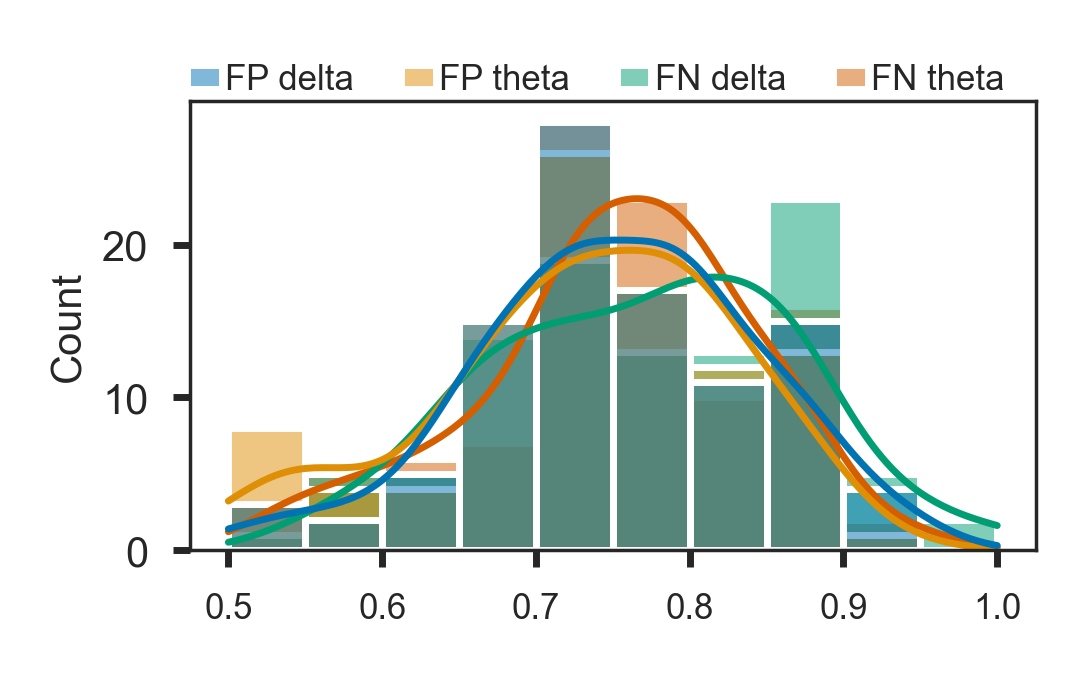

In [326]:
dpi = 500
cm=1/2.52

plt.rc('font', size=4)
sns.set_style("ticks")
sns.set_palette('colorblind')


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['axes.labelsize'] = 6
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=5)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2


g = sns.histplot(data=cv_results_df, bins=10, kde=True) # szerszy zbiór
sns.move_legend(g, "lower right", bbox_to_anchor=(-.02, 0.98,1,-1), ncol=4, title=None, 
                frameon=False,  
                mode='expand', 
                borderaxespad=0,
                labelspacing=0.1,
                handlelength = 1,
                handletextpad = 0.1
               )

fig = g.figure

fig.axes[0].tick_params(direction='out', length=2.5, width=1)

fig.set_size_inches(5.5*cm, 3*cm)
# fig.savefig(f'data/figure_2/dep_models', bbox_inches='tight', pad_inches=0.01)

---

#### Test differences between the best models

- delta

In [327]:
index = 0

In [328]:
dep_rewp_model = results_dep_rewp_stai_csp_df.iloc[index].best_model
dep_rewp_model

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('csp2',
                                                 Pipeline(steps=[('eeg',
                                                                  GetEEG()),
                                                                 ('csp',
                                                                  CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 2,
 'norm_trace': False,
 'rank': None,
 'reg': 0.1,
 'transform_into': 'average_power'})),
                                                                 ('vec',
                                                                  <mne.decoding.transformer.Vectorizer object at 0x7fe094157430>)])),
                                                ('stai',
                                                 Pipeline(steps=[('scale',
                                                                  GetScale())]))])),
                ('scaler', StandardScaler()),
                ('svc', SVC(C=0.1, kernel='linear'))])

In [329]:
dep_frn_model = results_dep_frn_stai_csp_df.iloc[index].best_model
dep_frn_model

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('csp2',
                                                 Pipeline(steps=[('eeg',
                                                                  GetEEG()),
                                                                 ('csp',
                                                                  CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 3,
 'norm_trace': False,
 'rank': None,
 'reg': 0.1,
 'transform_into': 'average_power'})),
                                                                 ('vec',
                                                                  <mne.decoding.transformer.Vectorizer object at 0x7fddde46e0d0>)])),
                                                ('stai',
                                                 Pipeline(steps=[('scale',
                                                                  GetScale())]))])),
                ('scaler', StandardScaler()),
                ('svc', SVC(C=1, kernel='linear'))])

In [330]:
X_rewp = rewp_depression_datasets[index]
X_frn = frn_depression_datasets[index]

In [331]:
y = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])

- Balanced Accuracy

In [332]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='balanced_accuracy'
)

In [333]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.572
p value: 0.284


- Roc AUC

In [334]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='roc_auc'
)

In [335]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 1.143
p value: 0.128


- precision

In [336]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='precision'
)

In [337]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.460
p value: 0.323


- recall

In [338]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='recall'
)

In [339]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.491
p value: 0.312


- F1

In [340]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='f1'
)

In [341]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.589
p value: 0.279


- theta

In [342]:
index = 1

In [343]:
dep_rewp_model = results_dep_rewp_stai_csp_df.iloc[index].best_model
dep_rewp_model

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('csp2',
                                                 Pipeline(steps=[('eeg',
                                                                  GetEEG()),
                                                                 ('csp',
                                                                  CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 2,
 'norm_trace': False,
 'rank': None,
 'reg': 0.1,
 'transform_into': 'average_power'})),
                                                                 ('vec',
                                                                  <mne.decoding.transformer.Vectorizer object at 0x7fdf825219d0>)])),
                                                ('stai',
                                                 Pipeline(steps=[('scale',
                                                                  GetScale())]))])),
                ('scaler', StandardScaler()),
                ('svc', SVC(C=0.1, kernel='linear'))])

In [344]:
dep_frn_model = results_dep_frn_stai_csp_df.iloc[index].best_model
dep_frn_model

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('csp2',
                                                 Pipeline(steps=[('eeg',
                                                                  GetEEG()),
                                                                 ('csp',
                                                                  CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 2,
 'norm_trace': False,
 'rank': None,
 'reg': 0.1,
 'transform_into': 'average_power'})),
                                                                 ('vec',
                                                                  <mne.decoding.transformer.Vectorizer object at 0x7fddd6fc5df0>)])),
                                                ('stai',
                                                 Pipeline(steps=[('scale',
                                                                  GetScale())]))])),
                ('scaler', StandardScaler()),
                ('svc', SVC(C=1, kernel='linear'))])

In [345]:
X_rewp = rewp_depression_datasets[index]
X_frn = frn_depression_datasets[index]

In [346]:
y = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])

Print confusion matrix

- RewP

In [243]:
y_true = y
y_pred = dep_rewp_model.predict(X_rewp)

pd.DataFrame(confusion_matrix(y_true, y_pred), columns = pd.MultiIndex.from_tuples(
    [
        ('Predicted','Negative'),
        ('Predicted', 'Positive'),
    ]
),
             index = pd.MultiIndex.from_tuples(
    [
        ('True','Negative'),
        ('True', 'Positive'),
    ]
),
            )


Predicted         
               Negative Positive
True Negative        23       49
     Positive         6       69

- FRN

In [244]:
from sklearn.metrics import confusion_matrix

y_true = y
y_pred = dep_frn_model.predict(X_frn)

pd.DataFrame(confusion_matrix(y_true, y_pred), columns = pd.MultiIndex.from_tuples(
    [
        ('Predicted','Negative'),
        ('Predicted', 'Positive'),
    ]
),
             index = pd.MultiIndex.from_tuples(
    [
        ('True','Negative'),
        ('True', 'Positive'),
    ]
),
            )


Predicted         
               Negative Positive
True Negative        42       30
     Positive        11       64

- Balanced Accuracy

In [347]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='balanced_accuracy'
)

In [348]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.751
p value: 0.227


- Roc AUC

In [349]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='roc_auc'
)

In [350]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.552
p value: 0.291


- precision

In [351]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='precision'
)

In [352]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.812
p value: 0.209


- recall

In [353]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='recall'
)

In [354]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 0.231
p value: 0.409


- F1

In [355]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=dep_rewp_model,
    estimator2=dep_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='f1'
)

In [356]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.464
p value: 0.322


### Anxiety RewP vs FRN

In [357]:
y = np.array(len(anx) * [1] +  len(ctrl_anx) * [0])

#### Plot differences between all Anxiety Models
To see which RewP and FRN models are the best

In [361]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_results_df = pd.DataFrame()

cv_scores_rewp_delta = cross_val_score(results_anx_rewp_bdi_csp_df.iloc[0].best_model, rewp_anxiety_datasets[0], y, cv=cv, scoring=scoring)
cv_scores_rewp_theta = cross_val_score(results_anx_rewp_bdi_csp_df.iloc[1].best_model, rewp_anxiety_datasets[1], y, cv=cv, scoring=scoring)
cv_scores_frn_delta = cross_val_score(results_anx_frn_bdi_csp_df.iloc[0].best_model, frn_anxiety_datasets[0], y, cv=cv, scoring=scoring)
cv_scores_frn_theta = cross_val_score(results_anx_frn_bdi_csp_df.iloc[1].best_model, frn_anxiety_datasets[1], y, cv=cv,scoring=scoring)
    
cv_results_df["FP delta"] = cv_scores_rewp_delta
cv_results_df["FP theta"] = cv_scores_rewp_theta
cv_results_df["FN delta"] = cv_scores_frn_delta
cv_results_df["FN theta"] = cv_scores_frn_theta

In [362]:
cv_results_df.head()

,FP delta,FP theta,FN delta,FN theta
0,0.500000,0.571429,0.571429,0.714286
1,0.619048,0.547619,0.535714,0.547619
2,0.559524,0.535714,0.630952,0.547619
3,0.619048,0.714286,0.702381,0.630952
4,0.464286,0.476190,0.619048,0.309524


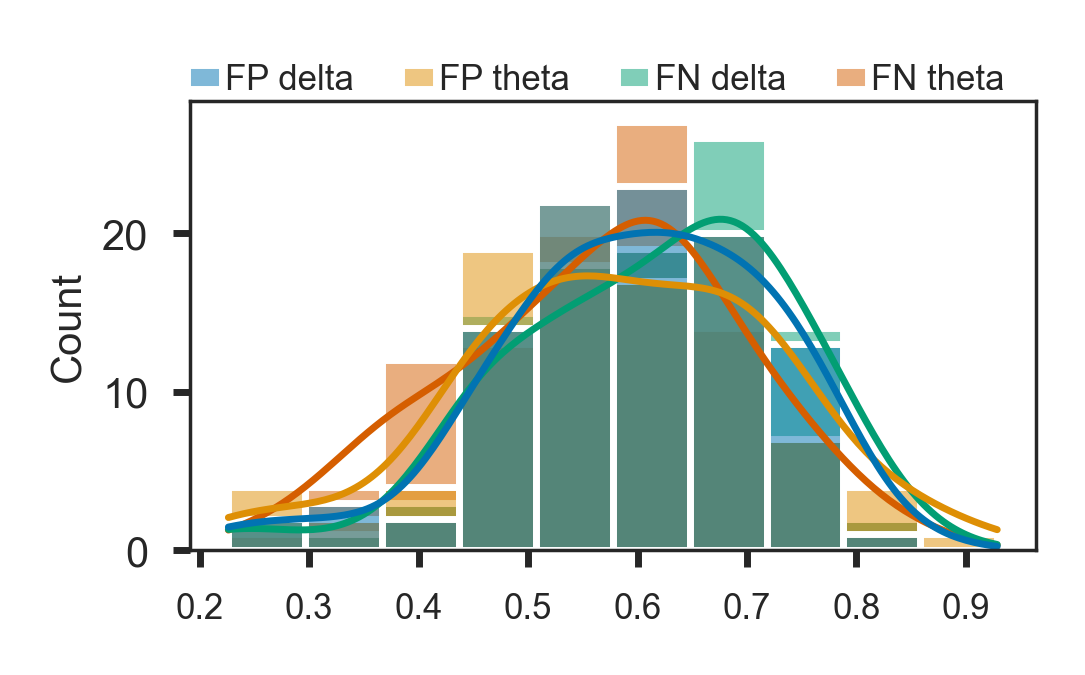

In [363]:
dpi = 500
cm=1/2.52

plt.rc('font', size=4)
sns.set_style("ticks")
sns.set_palette('colorblind')


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['axes.labelsize'] = 6
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=5)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2


g = sns.histplot(data=cv_results_df, bins=10, kde=True) # szerszy zbiór
sns.move_legend(g, "lower right", bbox_to_anchor=(-.02, 0.98,1,-1), ncol=4, title=None, 
                frameon=False,  
                mode='expand', 
                borderaxespad=0,
                labelspacing=0.1,
                handlelength = 1,
                handletextpad = 0.1
               )

fig = g.figure

fig.axes[0].tick_params(direction='out', length=2.5, width=1)

fig.set_size_inches(5.5*cm, 3*cm)
# fig.savefig(f'data/figure_2/anx_models', bbox_inches='tight', pad_inches=0.01)

#### Test differences between the best models

- delta

In [364]:
index = 0

In [365]:
anx_rewp_model = results_anx_rewp_bdi_csp_df.iloc[index].best_model
anx_rewp_model

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('csp2',
                                                 Pipeline(steps=[('eeg',
                                                                  GetEEG()),
                                                                 ('csp',
                                                                  CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 3,
 'norm_trace': False,
 'rank': None,
 'reg': 0.1,
 'transform_into': 'average_power'})),
                                                                 ('vec',
                                                                  <mne.decoding.transformer.Vectorizer object at 0x7fddd6fab9a0>)])),
                                                ('bdi',
                                                 Pipeline(steps=[('scale',
                                                                  GetScale())]))])),
                ('scaler', StandardScaler()),
                ('svc', SVC(C=0.1, kernel='linear'))])

In [366]:
anx_frn_model = results_anx_frn_bdi_csp_df.iloc[index].best_model
anx_frn_model

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('csp2',
                                                 Pipeline(steps=[('eeg',
                                                                  GetEEG()),
                                                                 ('csp',
                                                                  CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 3,
 'norm_trace': False,
 'rank': None,
 'reg': 0.1,
 'transform_into': 'average_power'})),
                                                                 ('vec',
                                                                  <mne.decoding.transformer.Vectorizer object at 0x7fddd311af10>)])),
                                                ('bdi',
                                                 Pipeline(steps=[('scale',
                                                                  GetScale())]))])),
                ('scaler', StandardScaler()),
                ('svc', SVC(C=0.1, kernel='linear'))])

In [367]:
X_rewp = rewp_anxiety_datasets[index]
X_frn = frn_anxiety_datasets[index]

In [368]:
y = np.array(len(anx) * [1] +  len(ctrl_anx) * [0])

- Balanced Accuracy

In [369]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='balanced_accuracy'
)

In [370]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.295
p value: 0.384


- Roc AUC

In [371]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='roc_auc'
)

In [372]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.241
p value: 0.405


- precision

In [374]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='precision'
)

In [375]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.356
p value: 0.361


- recall

In [376]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='recall'
)

In [377]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.069
p value: 0.473


- F1

In [378]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='f1'
)

In [379]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.244
p value: 0.404


- theta

In [318]:
index = 1

In [319]:
anx_rewp_model = results_anx_rewp_df.iloc[index].best_model
anx_rewp_model

Pipeline(steps=[('csp',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 2,
 'norm_trace': False,
 'rank': None,
 'reg': 0.01,
 'transform_into': 'average_power'})),
                ('vec',
                 <mne.decoding.transformer.Vectorizer object at 0x7fb0eb204910>),
                ('svc', SVC(C=1))])

In [320]:
anx_frn_model = results_anx_frn_df.iloc[index].best_model
anx_frn_model

Pipeline(steps=[('csp',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 1,
 'norm_trace': False,
 'rank': None,
 'reg': 1,
 'transform_into': 'average_power'})),
                ('vec',
                 <mne.decoding.transformer.Vectorizer object at 0x7fb0e2b6e190>),
                ('svc', SVC(C=1000))])

In [321]:
X_rewp = rewp_anxiety_datasets[index]
X_frn = frn_anxiety_datasets[index]

- Balanced Accuracy

In [308]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='balanced_accuracy'
)

In [309]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -1.080
p value: 0.141


- Roc AUC

In [310]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='roc_auc'
)

In [311]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -1.623
p value: 0.054


- precision

In [312]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='precision'
)

In [313]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -1.186
p value: 0.119


- recall

In [314]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='recall'
)

In [315]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.018
p value: 0.493


- F1

In [316]:
%%capture

t, p = paired_ttest_nandeu(
    estimator1=anx_rewp_model,
    estimator2=anx_frn_model,
    X_1=X_rewp,
    X_2=X_frn, 
    y=y,
    random_state=random_state,
    scoring='f1'
)

In [317]:
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -0.540
p value: 0.295


Visualize difference between FRN and RewP models

In [322]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(anx_rewp_model, X_rewp, y, cv=cv, scoring='roc_auc')
cv_scores_2 = cross_val_score(anx_frn_model, X_frn, y, cv=cv,  scoring='roc_auc')

In [323]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

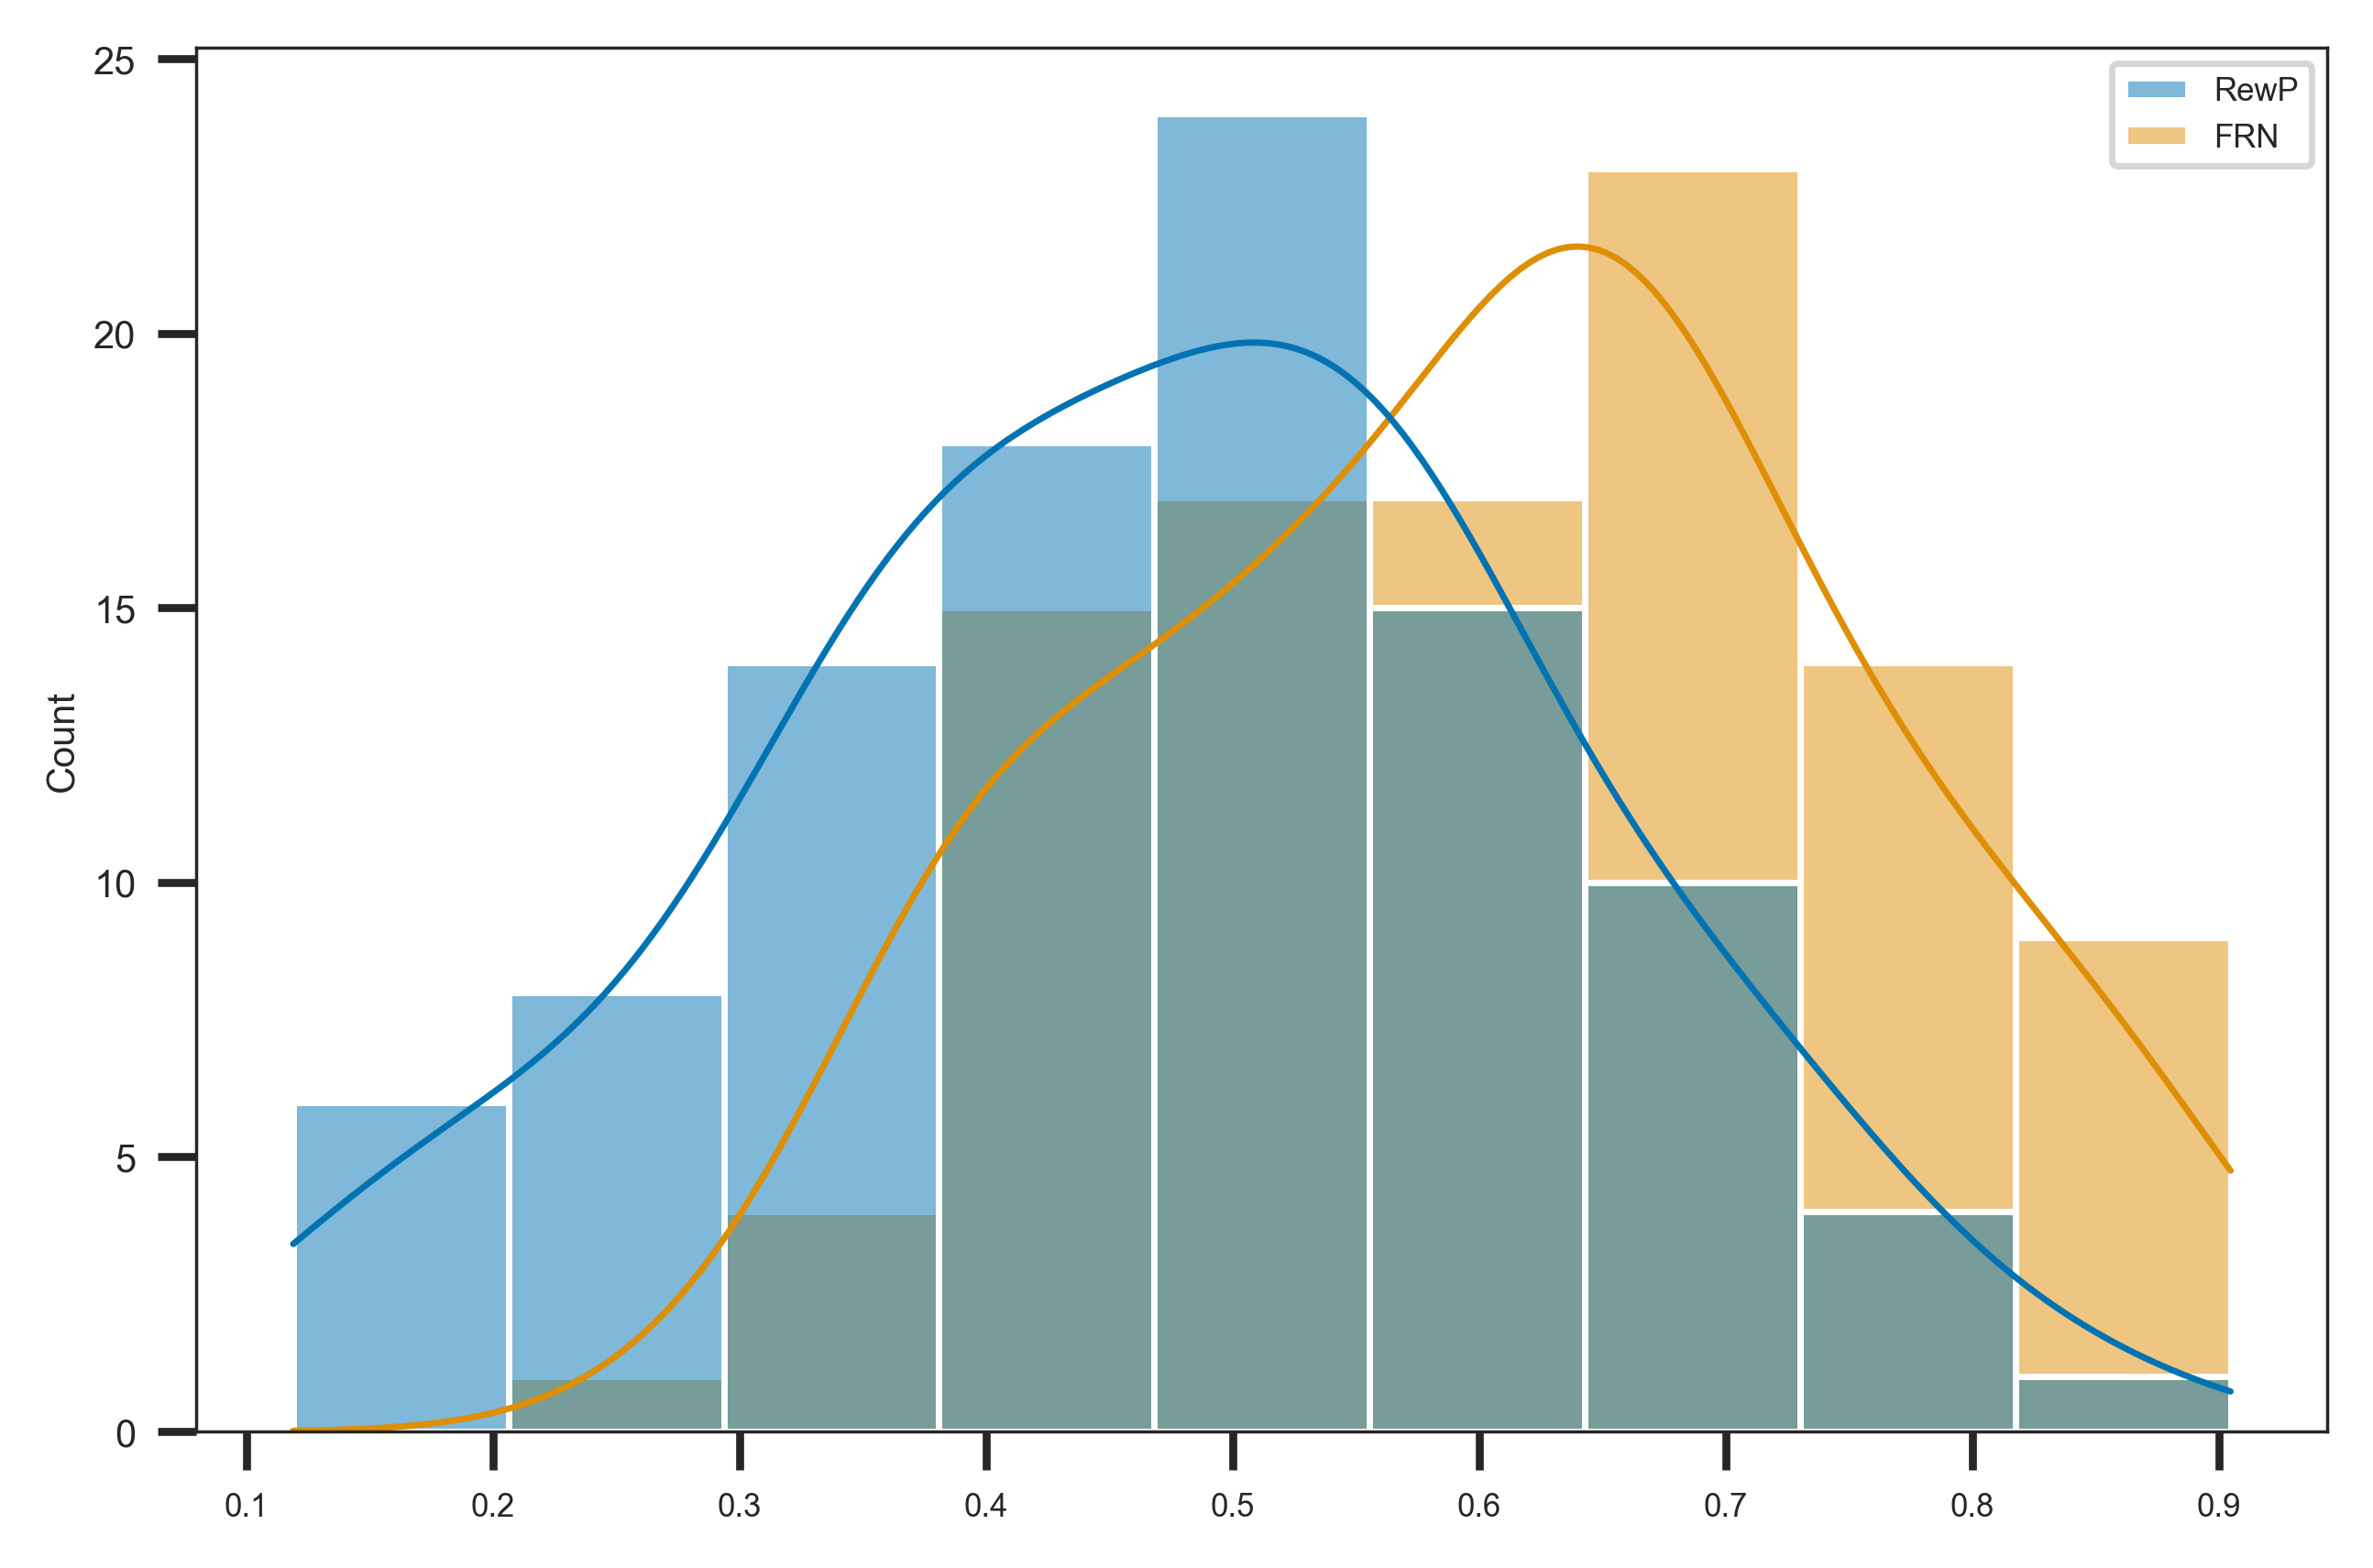

In [324]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)

In [172]:
%%capture

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

cv_scores_1 = cross_val_score(anx_rewp_model, X_rewp, y, cv=cv, scoring='recall')
cv_scores_2 = cross_val_score(anx_frn_model, X_frn, y, cv=cv,  scoring='recall')

In [173]:
cv_results_df = pd.DataFrame({
    "RewP": cv_scores_1,
    "FRN": cv_scores_2,
})

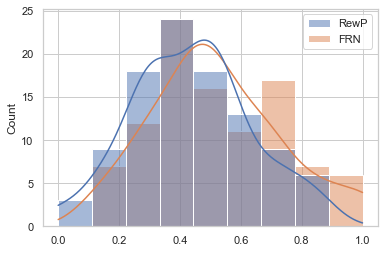

In [174]:
fig = sns.histplot(data=cv_results_df, bins=9, kde=True)